In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from utils import *
from datetime import datetime as dt
from datetime import timedelta
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

### recombination figure details

In [2]:
nCoV_gard_167vir = [0,1099,1829,2088,3181,3853,4426,5001,5571,8101,9027,9859,11994,12246,13086,15443,17498,18401,19886,20864,21735,22968,24036,25006,27842,28959,29380,31243]
genome_ann = [["Orf1ab",[465,21900]],["S",[21913,25893]],["Orf3a",[25903,26754]],["E",[26779,27009]],["M",[27060,27749]],["Orf6",[27760,28481]],["Orf7a",[28489,28866]],["Orf7b",[28863,28999]],["Orf8",[29006,29399]],["N",[29414,30687]],["Orf10",[30712,30832]]]
sc1_gard_167vir = [0,1943,2809,3232,4073,5337,6141,6879,8286,8853,9162,10626,12774,14969,16034,17159,18849,19994,20495,21365,21813,23000,23812,24259,24904,26272,26656,27297,27880,29021,29395,31243]
closebps = [4,20,21,24,25,26]
extra_feats = [["nsp2",[1005,2918],1],["nsp3",[2919,8890],1],["NTD",[22237,23201],0],["RBD",[23246,23978],0]]

## tProximal functions

In [3]:
def toDatestring(yearFraction):
    year = math.floor(yearFraction)
    remaining_days = (yearFraction-year)*365
    datestring = str(dt(year,1,1) + timedelta(remaining_days))[:10]
    return datestring


def load_data(directory, sc, pre='NRR'):
    combined_df = pd.DataFrame()
    column = 'age(sc%i)' % sc
    burnins = pd.read_csv(os.path.join(directory,'burnins.tsv'), sep='\t')
    for row in burnins.iterrows():
        if row[1]['min_burnin_percent'] < 0 or ('+' in row[1]['file']):
            continue
        print('Loading %s' % row[1]['file'])
        nrr = row[1]['file'].split(pre)[-1].split('.')[0]
        df = pd.read_csv(os.path.join(directory, row[1]['file']), sep='\t', comment='#').iloc[(row[1]['min_burnin_states']):]
        combined_df[nrr] = df[column]
    return combined_df

def generate_tProximal_df(directory, sc):
    sc_df = load_data(directory, sc)
    sc_all_df = pd.DataFrame()
    sc_95hpd_df = pd.DataFrame()
    sc_tmrca_string_summary = []
    sc_tmrca_medians = {}
    for col in sc_df.columns:
        temp = sc_df[col][~sc_df[col].isna()]
        hpd_vals = hpd_single(temp, 0.05)
        median = np.median(temp)
        temp_95hpd = [x for x in temp if x > hpd_vals[0] and x < hpd_vals[1]]
        if len(temp_95hpd) < len(sc_95hpd_df):
            temp_95hpd += ([np.nan] * (len(sc_95hpd_df) - len(temp_95hpd)))
        sc_95hpd_df[col] = temp_95hpd
        sc_all_df[col] = temp
        sc_tmrca_string_summary.append([col, ('%s (%s to %s)' % (toDatestring(median), toDatestring(hpd_vals[0]), toDatestring(hpd_vals[1])))])
        sc_tmrca_medians[int(col)] = median
    return sc_95hpd_df, sc_tmrca_medians, sc_all_df


def plot_tPrimary(sc_95hpd_df, sc_tmrca_medians, sc, ax1, ax2, facecolor='lightgrey', include_top_panel_xticklabels=False, color='grey', alpha=0.7):
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 

    if sc == 1:
        large_year_spacing = [1940,1960,1980,2000]
        small_year_spacing = [1985,2005]
        first_sc_case_date = toYearFraction('2002-11-16')
        num_regions = 31
    elif sc == 2:
        large_year_spacing = [1900,1930,1960,1990,2020]
        small_year_spacing = [2002,2022]
        first_sc_case_date = toYearFraction('2019-12-10')
        num_regions = 27

    sns.violinplot(  data = sc_95hpd_df,  whis=10, orient='v', inner=None, color=color, ax=ax1, cut=0)
    sns.violinplot(  data = sc_95hpd_df,  whis=10, orient='v', inner=None, color=color, ax=ax2, cut=0)
    ax2.scatter([x-1 for x in sc_tmrca_medians.keys()], sc_tmrca_medians.values(), marker='.', color='black', alpha=0.5)
    ax1.hlines(first_sc_case_date, -1, num_regions + 1, linestyle='--', color='grey')
    ax1.set_xlim(-1,num_regions)
    ax1.set_xticklabels(labels=[])
    ax1.set_yticks(large_year_spacing)

    for violin in ax1.collections[::]:
        violin.set_alpha(alpha)
    for violin in ax2.collections[::]:
        violin.set_alpha(alpha)

    if include_top_panel_xticklabels:
        ax1.set_xticklabels(labels=[x for x in sc_tmrca_medians.keys()])
    ax2.set_xticklabels(labels=[x for x in sc_tmrca_medians.keys()])
    ax2.set_xlabel('Fragment', fontsize=22)
    ax2.hlines(first_sc_case_date, -1, num_regions + 1, linestyle='--', color='grey')
    ax2.set_xlim(-1,num_regions)
    ax2.set_ylim(small_year_spacing)

    # make grey box in first panel to show where second panel is
    ax1.add_patch(
        patches.Rectangle(
            (-1, small_year_spacing[0]),   # (x,y)
            32,          # width
            small_year_spacing[1]-small_year_spacing[0],          # height
            facecolor=facecolor,
            edgecolor='none',
            zorder=0
        )
    )
    
    ax2.set_facecolor(facecolor)
    return ax1, ax2

sc1_directory = '../../../beast_results/SC1/' # path to SC1 beast results (log files)
sc2_directory = '../../../beast_results/SC2_late2020/' # path to SC2 beast results (log files)

sc1_95hpd_df, sc1_tmrca_medians, sc1_all_df = generate_tProximal_df(sc1_directory, 1)
sc2_95hpd_df, sc2_tmrca_medians, sc2_all_df = generate_tProximal_df(sc2_directory, 2)

Loading SC1.NRR01.log
Loading SC1.NRR02.log
Loading SC1.NRR03.log
Loading SC1.NRR04.log
Loading SC1.NRR05.log
Loading SC1.NRR06.log
Loading SC1.NRR07.log
Loading SC1.NRR08.log
Loading SC1.NRR09.log
Loading SC1.NRR10.log
Loading SC1.NRR11.log
Loading SC1.NRR12.log
Loading SC1.NRR13.log
Loading SC1.NRR14.log
Loading SC1.NRR15.log
Loading SC1.NRR16.round2.log
Loading SC1.NRR17.log
Loading SC1.NRR18.log
Loading SC1.NRR19.log
Loading SC1.NRR20.log
Loading SC1.NRR21.log
Loading SC1.NRR22.log
Loading SC1.NRR23.log
Loading SC1.NRR24.log
Loading SC1.NRR25.log
Loading SC1.NRR26.log
Loading SC1.NRR27.log
Loading SC1.NRR28.log
Loading SC1.NRR29.log
Loading SC1.NRR30.log
Loading SC1.NRR31.log
Loading SC2.NRR01.late2020.log
Loading SC2.NRR02.late2020.log
Loading SC2.NRR03.late2020.log
Loading SC2.NRR04.late2020.log
Loading SC2.NRR05.late2020.log
Loading SC2.NRR06.late2020.log
Loading SC2.NRR07.late2020.log
Loading SC2.NRR08.late2020.log
Loading SC2.NRR09.late2020.log
Loading SC2.NRR10.late2020.log
L

# Combine with timing figures

/Users/jonathanpekar/opt/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanpekar/opt/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanpekar/opt/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanpekar/opt/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

Text(-0.05, 1.3, 'c')

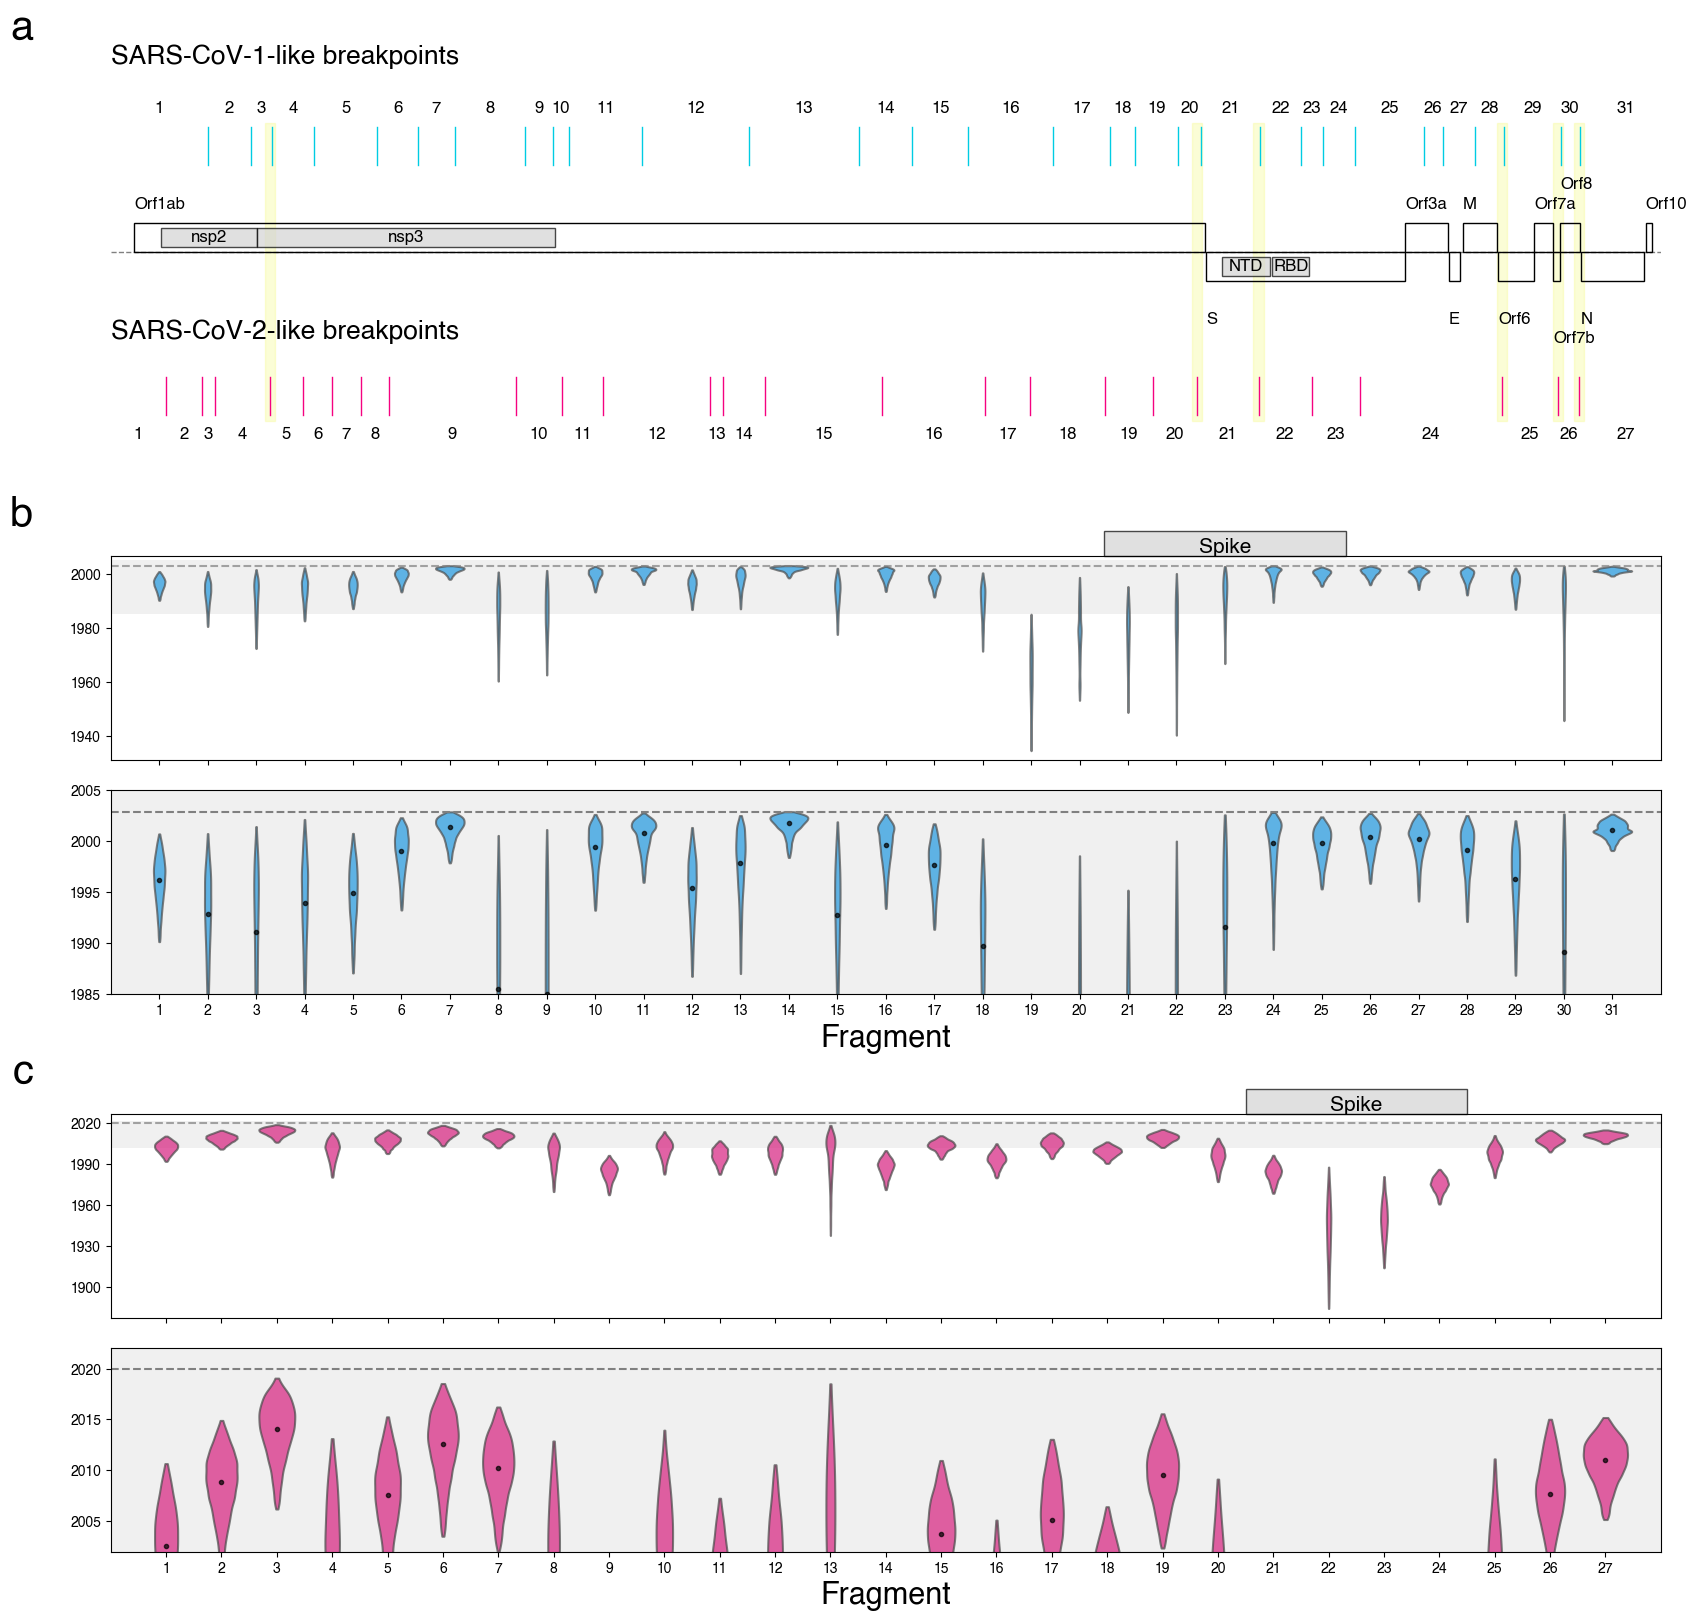

In [4]:
w = 600
h = 300
marg = 0

rcParams['font.family'] = 'Helvetica'

plt.figure(figsize=(w/30, 5*h/80))
plt.subplots_adjust(hspace=.3)
gs1 = GridSpec(5, 1)

#make outer gridspec
outer = gridspec.GridSpec(3, 1, height_ratios = [1.5,2,2]) 
#make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0], hspace = .25)
gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1], hspace = .15)
gs3 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[2], hspace = .15)

ax00 = plt.subplot(gs1[0])
ax01 = plt.subplot(gs2[0])
ax02 = plt.subplot(gs2[1])
ax03 = plt.subplot(gs3[0])
ax04 = plt.subplot(gs3[1])
axes = [ax00, ax01, ax02, ax03, ax04]

############################################################################################################################################################################
########################################################################## panel 1: recombination ##########################################################################
############################################################################################################################################################################

genomefit = (w-2*marg)/nCoV_gard_167vir[-1]
bpheight = 20
fontsize = 12
large_fontsize = 19

# SC2 bps
for i in range(1, len(nCoV_gard_167vir) - 1):
    if i in closebps:
        axes[0].add_patch(plt.Rectangle((marg + nCoV_gard_167vir[i]*genomefit - 2, h/3 - bpheight - 3), 4, 2*h/3 + bpheight - 65, color='#f4fa7a', alpha=0.3))
    axes[0].plot([marg + nCoV_gard_167vir[i]*genomefit, marg + nCoV_gard_167vir[i]*genomefit], [h/3 - bpheight, h/3], color='#f50280', linewidth=1)

# SC2 NRR numbering
for i in range(1, len(nCoV_gard_167vir)):
    axes[0].text(marg + nCoV_gard_167vir[i-1]* genomefit + ((nCoV_gard_167vir[i] - nCoV_gard_167vir[i-1])/2)*genomefit, h/3 - bpheight*1.3, i, color='black', fontsize=fontsize, horizontalalignment='center', verticalalignment='top')

axes[0].text(0 + marg, h/3 + bpheight*1.5, 'SARS-CoV-2-like breakpoints', color='black', fontsize=large_fontsize, horizontalalignment='left', verticalalignment='top')

# SC1 bps
for i in range(1, len(sc1_gard_167vir) - 1):
    axes[0].plot([marg + sc1_gard_167vir[i]*genomefit, marg + sc1_gard_167vir[i]*genomefit], [2*h/3 + 10, 2*h/3 + 10 + bpheight], color='#00cce3', linewidth=1)

# SC1 NRR numbering
for i in range(1, len(sc1_gard_167vir)):
    axes[0].text(marg + sc1_gard_167vir[i-1]* genomefit + ((sc1_gard_167vir[i] - sc1_gard_167vir[i-1])/2)*genomefit, 2*h/3 + 10 + bpheight*1.3, i, color='black', fontsize=fontsize, horizontalalignment='center', verticalalignment='bottom')

axes[0].text(0 + marg, 2*h/3 + 10 + bpheight*2.5, 'SARS-CoV-1-like breakpoints', color='black', fontsize=large_fontsize, horizontalalignment='left', verticalalignment='bottom')

# ORF diagram
for i, o in enumerate(genome_ann):
    x = marg + (o[1][0] * genomefit)
    y = h / 2 if genome_ann.index(o) % 2 == 1 else h / 2 + 15
    width = (o[1][1] - o[1][0]) * genomefit
    height = 15

    axes[0].add_patch(plt.Rectangle((x, y), width, height, fill=None, color="black", linewidth=1))

    x_text = marg + (o[1][0] * genomefit)
    y_text = h / 2 - 20 if genome_ann.index(o) % 2 == 1 else h / 2 + 40
    if o[0] == 'Orf7b':
        y_text = h / 2 - 30
    elif o[0] == 'Orf8':
        y_text = h / 2 + 50
    
    axes[0].text(x_text, y_text, o[0], fontsize=fontsize, color="black", horizontalalignment='left', verticalalignment='center')
axes[0].hlines(h/2 + 15, marg, genomefit*31017 + marg, color='grey', linewidth=1, linestyle='dashed', zorder=0)

# extra features
for e in extra_feats:
    x = marg + (e[1][0] * genomefit)
    y = h / 2 + 2.5 + (e[2] * 15)
    width = (e[1][1] - e[1][0]) * genomefit
    height = 10

    axes[0].add_patch(plt.Rectangle((x, y), width, height, fc="lightgrey", alpha=0.7, ec="black", linewidth=1))
    axes[0].text(x + width/2, y + height/2, e[0], fontsize=fontsize, color="black", horizontalalignment='center', verticalalignment='center')

# adjust axes, remove all axes and ticks
axes[0].set_xlim(0, genomefit*31017 + marg)
axes[0].axes.get_xaxis().set_visible(False)
axes[0].axes.get_yaxis().set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)


############################################################################################################################################################################
########################################################################## panel 2: tProximal, SC1 #########################################################################
############################################################################################################################################################################
fontsize=15
facecolor = [(mpl.colors.to_rgb('whitesmoke')[0] + mpl.colors.to_rgb('lightgrey')[0])/2] * 3
facecolor = [0.94] * 3
sc2_color = '#f50280'
sc1_color = '#00a0ff'


ax1, ax2 = plot_tPrimary(sc1_95hpd_df, sc1_tmrca_medians, 1, axes[1], axes[2], facecolor=facecolor, color=sc1_color, alpha=0.7)

# add box above NRRs 21-25 in ax1 to indicate that this is the spike gene
ax1.add_patch(plt.Rectangle((20.5/32, 1), 5/32, .125, transform=ax1.transAxes, fill=True, facecolor='lightgrey', alpha=0.7, edgecolor='black', linewidth=1, clip_on=False))
ax1.text((20.5 + 5/2)/32, 1, 'Spike', color='black', transform=ax1.transAxes, fontsize=fontsize, horizontalalignment='center', verticalalignment='bottom')


############################################################################################################################################################################
########################################################################## panel 3: tProximal, SC2 #########################################################################
############################################################################################################################################################################

ax1, ax2 = plot_tPrimary(sc2_95hpd_df, sc2_tmrca_medians, 2, axes[3], axes[4], facecolor=facecolor, color=sc2_color, alpha=0.7)

# add box above NRRs 21-24 in ax1 to indicate that this is the spike gene
ax1.add_patch(plt.Rectangle((20.5/28, 1), 4/28, .125, transform=ax1.transAxes, fill=True, facecolor='lightgrey', alpha=0.7, edgecolor='black', linewidth=1, clip_on=False))
ax1.text((20.5 + 4/2)/28, 1, 'Spike', color='black', transform=ax1.transAxes, fontsize=fontsize, horizontalalignment='center', verticalalignment='bottom')


axes[0].text(-0.05, 1.3, 'a', transform=axes[0].transAxes, fontsize=30, va='top', ha='right', weight='bold')
axes[1].text(-0.05, 1.3, 'b', transform=axes[1].transAxes, fontsize=30, va='top', ha='right', fontweight='bold')
axes[3].text(-0.05, 1.3, 'c', transform=axes[3].transAxes, fontsize=30, va='top', ha='right', fontweight='bold')
